In [30]:
import json
import pandas as pd 
import ipdb
import os
import pickle as pkl
import os.path as osp
import numpy as np
from PIL import Image

In [31]:
# Load Agniv VITpose-base hot dict
filter_path = "./agniv_pose_filter/hot_dict.pkl"
with open(filter_path, 'rb') as f:
    pose_md_dict = pkl.load(f)
    
vcoco_dict = {}

for k, v in pose_md_dict.items():
    if 'vcoco' in k:
        vcoco_dict[k] = v
    
print(f'Total images found: {len(vcoco_dict)}')

# Filter out images with < 10 visible keypoints 
kp_thresh = 10

filter_img_names = {}

for imgname, kp_md in vcoco_dict.items():
    if kp_md == 0:
        continue
    if kp_md["num_persons"] == 1 and kp_md["num_kpt"][0.5][0] > kp_thresh:
        filter_img_names[imgname] = kp_md["num_kpt"][0.5][0]
        
print(f'Images after KP filtering: {len(filter_img_names)}')

print(list(filter_img_names.keys())[:5])

Total images found: 5459
Images after KP filtering: 2386
['vcoco_000000051899.jpg', 'vcoco_000000093127.jpg', 'vcoco_000000455665.jpg', 'vcoco_000000248389.jpg', 'vcoco_000000403947.jpg']


In [35]:
from pycocotools.coco import COCO
version = '1'
out_dir = f'./filtered_data/v_{version}/vcoco'
os.makedirs(out_dir, exist_ok=True)

coco_dir = '/is/cluster/work/stripathi/pycharm_remote/v-coco/data'
coco = COCO(os.path.join(coco_dir, 'instances_vcoco_all_2014.json'))

imgwise_object_names = {}
img_dir = '/ps/project/datasets/HOT/Contact_Data/images/training/'

bad_object_names = ['bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
                    'elephant', 'bear', 'zebra', 'giraffe']

# # Get all coco objects
# count = 0
# for id in range(91):
#     try: 
#         print(coco.loadCats(id))
#         count += 1
#     except:
#         print(f'ID:{id} does not exist')
#         continue
# print(count)

objectwise_img_names = {}
for img_name in filter_img_names.keys():
    img_id = int(os.path.splitext(img_name.split('_')[-1])[0])
    ann_ids = coco.getAnnIds([img_id])
    anns = coco.loadAnns(ann_ids)
    object_list = []
    for ann in anns:
        object_cat = coco.loadCats(ann["category_id"])
        if len(object_cat) > 1:
            ipdb.set_trace()
        object_name = object_cat[0]['name']
        if object_name in bad_object_names:
            continue
        if object_name != 'person':
            object_list.append(object_name)
    if len(object_list) != 0:
        imgwise_object_names[img_name] = list(set(object_list))
        
    for obj_name in set(object_list):
        objectwise_img_names.setdefault(obj_name,[]).append(img_name)
        
#         # Visualize images 
#         print(img_name)
#         print(list(set(object_list)))
#         img = Image.open(osp.join(img_dir,img_name))
#         display(img)
    
    
print(f'Final number of images {len(imgwise_object_names)}')
    


loading annotations into memory...
Done (t=1.30s)
creating index...
index created!
Final number of images 2368


In [36]:
# Save the imagewise_object dict
out_path = osp.join(out_dir, 'object_per_image_dict.json')
with open(out_path, 'w') as fp:
    json.dump(imgwise_object_names, fp)
    print(f'saved at {out_path}')
    
# save image_list 
out_path = osp.join(out_dir, 'vcoco_imglist_all_170223.txt')
with open(out_path, 'w') as f:
    f.write('\n'.join(imgwise_object_names.keys()))
    print(f'saved at {out_path}')


# Save the object_wise dict
out_path = osp.join(out_dir, 'imgnames_per_object_dict.json')
with open(out_path, 'w') as fp:
    json.dump(objectwise_img_names, fp)
    print(f'saved at {out_path}')

    

    

saved at ./filtered_data/v_1/vcoco/object_per_image_dict.json
saved at ./filtered_data/v_1/vcoco/vcoco_imglist_all_170223.txt
saved at ./filtered_data/v_1/vcoco/imgnames_per_object_dict.json


5072


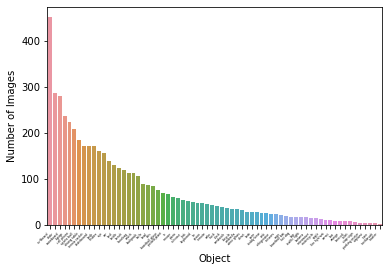

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# sort the dictionary 
objectwise_img_names = dict(sorted(objectwise_img_names.items(), key=lambda x: len(x[1]), reverse=True))

# Extract object names and image counts
obj_names = list(objectwise_img_names.keys())
img_counts = [len(objectwise_img_names[obj]) for obj in objectwise_img_names]
print(sum(img_counts))

# Create bar plot
sns.barplot(x=obj_names, y=img_counts)

# Add x-axis and y-axis labels
plt.xlabel('Object')
plt.ylabel('Number of Images')

plt.xticks(rotation=45, ha='right', fontsize=3)

# Save the plot as a high-resolution image file
out_path = osp.join(out_dir, 'image_per_object_category.png')
plt.savefig(out_path, dpi=300)

# Show plot
plt.show()